In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from operator import add, sub

np.random.seed(2017)

In [2]:
from pyspark import SparkContext

sc.stop()

#SparkContext.setSystemProperty('spark.executor.memory', '2g')
#SparkContext.setSystemProperty('spark.executor.cores', '4')
#SparkContext.setSystemProperty('spark.driver.memory', '2g')

#pyspark --executor-cores 4 --executor-memory 4g --driver-memory 2g  --conf spark.yarn.executor.memoryOverhead=4096

sc = SparkContext("local", "App Name")

sc.setSystemProperty('spark.executor.memory', '2g')
sc.setSystemProperty('spark.executor.cores', '4')
sc.setSystemProperty('spark.driver.memory', '2g')

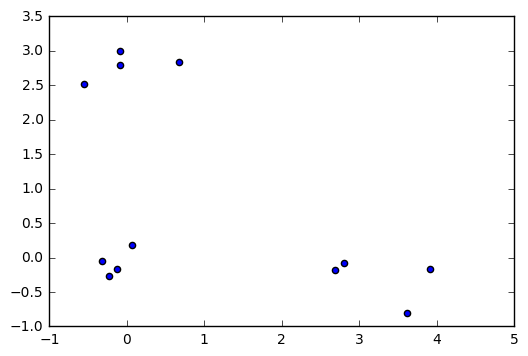

In [3]:
# Temporary cell. To be deleted later

N = 4

x_1 = np.random.multivariate_normal(mean = [0,0], cov = [[0.1,0],[0,0.1]], size = N)
x_2 = np.random.multivariate_normal(mean = [3,0], cov = [[0.3,-0.1],[-0.1,0.2]], size = N)
x_3 = np.random.multivariate_normal(mean = [0,3], cov = [[0.2,0],[0,0.2]], size = N)
N = 3 * N
X = np.concatenate((x_1, x_2, x_3))

plt.scatter(X[:,0], X[:,1])
plt.show()

pd.DataFrame(X).to_csv("gaussian_data.csv", sep="\t", header=None, index=True)

In [3]:
#Permet de convertir le RDD en Data Frame. On pourra directement créer un dataframe plus tard
from pyspark.sql.types import *

sql_c = SQLContext(sc)

lines = sc.textFile("gaussian_data.csv")
parts = lines.map(lambda l: l.split("\t"))

# Each line is converted to a tuple.
data = parts.map(lambda p: (int(p[0]), float(p[1]), float(p[2])))
#data = parts.map(lambda p: (float(p[1]), float(p[2])))

# Apply the schema to the RDD.
spark_data = sql_c.createDataFrame(data, schema=("index","x1","x2"))
#spark_data = sql_c.createDataFrame(data, schema=("x1","x2"))

In [20]:
spark_data.printSchema()

root
 |-- index: long (nullable = true)
 |-- x1: double (nullable = true)
 |-- x2: double (nullable = true)



In [21]:
spark_data.show()

+-----+--------------------+--------------------+
|index|                  x1|                  x2|
+-----+--------------------+--------------------+
|    0|-0.32348370312099217|-0.04439774349688147|
|    1|  0.0629585045493585| 0.18134902706122666|
|    2| -0.1247764738311745|-0.16704490375482864|
|    3| -0.2351423604041935|-0.26804989117924266|
|    4|  2.6862027295781523|-0.17691842971400198|
|    5|  3.6127378495457303| -0.7978262411909502|
|    6|  3.9101371436256858|-0.16402333935541125|
|    7|   2.803154714725354| -0.0731413132245947|
|    8|-0.08914572728042147|  2.8013828859258862|
|    9| -0.5521156252383028|   2.512836733774541|
|   10|  0.6754209723875768|   2.842196629280239|
|   11|-0.09335682900449731|  2.9949710227720954|
+-----+--------------------+--------------------+



In [4]:
#Cette instruction permet d'autoriser les produits cartésiens. Sinon, spark bloque
sql_c.setConf("spark.sql.crossJoin.enabled", True)

#L'instruction createOrReplaceTempView permet de créer uen View pour effectuer des opérations SQL
spark_data.createOrReplaceTempView("data")

sql_c.sql("SELECT * FROM data d1 JOIN data d2").show()

+-----+--------------------+--------------------+-----+--------------------+--------------------+
|index|                  x1|                  x2|index|                  x1|                  x2|
+-----+--------------------+--------------------+-----+--------------------+--------------------+
|    0|-0.32348370312099217|-0.04439774349688147|    0|-0.32348370312099217|-0.04439774349688147|
|    0|-0.32348370312099217|-0.04439774349688147|    1|  0.0629585045493585| 0.18134902706122666|
|    0|-0.32348370312099217|-0.04439774349688147|    2| -0.1247764738311745|-0.16704490375482864|
|    0|-0.32348370312099217|-0.04439774349688147|    3| -0.2351423604041935|-0.26804989117924266|
|    0|-0.32348370312099217|-0.04439774349688147|    4|  2.6862027295781523|-0.17691842971400198|
|    0|-0.32348370312099217|-0.04439774349688147|    5|  3.6127378495457303| -0.7978262411909502|
|    0|-0.32348370312099217|-0.04439774349688147|    6|  3.9101371436256858|-0.16402333935541125|
|    0|-0.3234837031

In [5]:
#Permet de faire le produit cartésien. Je n'ai pas réussi à faire fonctionner la fonction pow() ou power(), donc je fait le carré manuellement
cartesian_similarities = sql_c.sql("SELECT d1.index as x1_index, d2.index as x2_index, -((d1.x1 - d2.x1) * (d1.x1 - d2.x1)) as similarity_x1, -((d1.x2 - d2.x2) * (d1.x2 - d2.x2)) as similarity_x2  FROM data d1 JOIN data d2")
#cartesian_similarities = sql_c.sql("SELECT -((d1.x1 - d2.x1) * (d1.x1 - d2.x1)) as similarity_x1, -((d1.x2 - d2.x2) * (d1.x2 - d2.x2)) as similarity_x2  FROM data d1 JOIN data d2")
cartesian_similarities.show()

+--------+--------+--------------------+--------------------+
|x1_index|x2_index|       similarity_x1|       similarity_x2|
+--------+--------+--------------------+--------------------+
|       0|       0|                -0.0|                -0.0|
|       0|       1|-0.14933757986913443|-0.05096160441741512|
|       0|       2|-0.03948456297203617|-0.01504232591933...|
|       0|       3|-0.00780419283300...| -0.0500202831629327|
|       0|       4|  -9.058212423173302|-0.01756173227545...|
|       0|       5| -15.493840111678022| -0.5676545011375415|
|       0|       6| -17.923545474008062|-0.01431028318450...|
|       0|       7|  -9.775867795952703|-8.26192800691912...|
|       0|       8| -0.0549142869210559|  -8.098467390797843|
|       0|       9|-0.05227255581105...|  -6.539448171745646|
|       0|      10| -0.9978105507528795|  -8.332427072948537|
|       0|      11|-0.05295837819062907|  -9.237762497371403|
|       1|       0|-0.14933757986913443|-0.05096160441741512|
|       

In [6]:
#Créer une View du produit cartésien
cartesian_similarities.createOrReplaceTempView("cartesian_similarities")

#Somme des similarités + création d'une view
sum_similarites = sql_c.sql("SELECT x1_index, x2_index, (similarity_x1 + similarity_x2) as similarity_without_diagonal FROM cartesian_similarities")
sum_similarites.createOrReplaceTempView("sum_similarites")

#Calcul de la médiane // On supprime les 0 et on calcule la médiane
sum_similarites_without_diagonal = sql_c.sql("SELECT *  FROM sum_similarites HAVING similarity_without_diagonal != 0")
sum_similarites.createOrReplaceTempView("sum_similarites_without_diagonal")

#Mediane est fausse
median = sum_similarites_without_diagonal.approxQuantile("similarity_without_diagonal", [0.5], 0)[0]

#Remplace la diagonale par la médiane
similarity_matrix = sql_c.sql("SELECT x1_index, x2_index, if(similarity_without_diagonal=0, '%s', similarity_without_diagonal) as similarities FROM sum_similarites" % median)
similarity_matrix.createOrReplaceTempView("Similarity_matrix")
similarity_matrix.show()

+--------+--------+--------------------+
|x1_index|x2_index|        similarities|
+--------+--------+--------------------+
|       0|       0|  -9.075774155448759|
|       0|       1|-0.20029918428654955|
|       0|       2|-0.05452688889137475|
|       0|       3|-0.05782447599593958|
|       0|       4|  -9.075774155448759|
|       0|       5| -16.061494612815565|
|       0|       6|  -17.93785575719257|
|       0|       7|  -9.776693988753395|
|       0|       8|    -8.1533816777189|
|       0|       9| -6.5917207275567025|
|       0|      10|  -9.330237623701416|
|       0|      11|  -9.290720875562032|
|       1|       0|-0.20029918428654955|
|       1|       1|  -9.075774155448759|
|       1|       2|-0.15662275313700152|
|       1|       3| -0.2908235134017599|
|       1|       4|  -7.009765834731108|
|       1|       5| -13.559717604119594|
|       1|       6| -14.920065552449412|
|       1|       7|  -7.573440603561684|
+--------+--------+--------------------+
only showing top

In [8]:
#Création de RDD availability puis responsibiity puis conversion en spark dataframes. Pas top mais ça marche

# Create A and R matrices
A = sc.parallelize(range(N)).flatMap(lambda x: [(x, y, 0) for y in range(N)])
R = sc.parallelize(range(N)).flatMap(lambda x: [(x, y, 0) for y in range(N)])

# Each line is converted to a tuple.
A = A.map(lambda p: (int(p[0]), int(p[1]), float(p[2])))
R = R.map(lambda p: (int(p[0]), int(p[1]), float(p[2])))

# Apply the schema to the RDD.
A_spark = sql_c.createDataFrame(A, schema=("x1_index","x2_index","availability"))
R_spark = sql_c.createDataFrame(R, schema=("x1_index","x2_index","responsibility"))

#Créé les tables sql
A_spark.createOrReplaceTempView("availability_matrix")
R_spark.createOrReplaceTempView("responsibility_matrix")

lambdaValue = 0.5

In [9]:
def computeR(): #computeR(A, R, S, N)
    # Compute the sum of A and S
    sum_A_S = sql_c.sql("SELECT t.x1_index, t.x2_index, sum(t.sim_availability) as sim_availability FROM(SELECT  x1_index, x2_index, similarities as sim_availability FROM similarity_matrix UNION ALL SELECT x1_index, x2_index, availability as sim_availability FROM availability_matrix)t GROUP BY t.x1_index, t.x2_index ORDER BY t.x1_index, t.x2_index") 
    sum_A_S.createOrReplaceTempView("sum_A_S")

    # Remove all rows where i == k and compute the maximum
    sum_A_S_cartesian = sql_c.sql("SELECT  d.index, s.x2_index, s.x1_index, s.sim_availability FROM data d JOIN sum_A_S s WHERE d.index != s.x2_index")
    sum_A_S_cartesian.createOrReplaceTempView("sum_A_S_cartesian")
    maximum = sql_c.sql("SELECT x1_index, index, max(sim_availability) as maximum FROM sum_A_S_cartesian GROUP BY x1_index, index")
    maximum.createOrReplaceTempView("maximum")

    # Compute r
    responsibility_matrix_updated = sql_c.sql("SELECT x1_index, x2_index, sum(r_value) as r FROM (SELECT x1_index, x2_index, similarities as r_value FROM Similarity_matrix UNION ALL SELECT x1_index, index as x2_index, maximum*(-1) as r_value FROM maximum)t GROUP BY t.x1_index, t.x2_index")
    responsibility_matrix_updated.createOrReplaceTempView("responsibility_matrix_updated")
    
    #DOUBLE JOINTURE ?? --> possible source d'erreur
    # Compute R
    R_updated = sql_c.sql("SELECT rmu.x1_index, rmu.x2_index, ((1 - 0.5)* rmu.r) + (0.5 * rm.responsibility) as responsibility_updated FROM responsibility_matrix rm JOIN responsibility_matrix_updated rmu ON rm.x1_index = rmu.x1_index AND rm.x2_index = rmu.x2_index") #% lambdaValue  
    R_updated.createOrReplaceTempView("R_updated")
    
    return R_updated

test = computeR()
test.show()

+--------+--------+----------------------+
|x1_index|x2_index|responsibility_updated|
+--------+--------+----------------------+
|       3|       0|  -0.01772091979614...|
|       8|       7|    -8.295398559111602|
|       3|       5|    -7.532231227376172|
|       4|       0|    -4.525663349356016|
|      11|      11|    -4.519140027671721|
|       2|       6|    -8.129077196893286|
|       1|       3|  -0.06710038013237918|
|       7|       8|    -8.301921880795897|
|       9|       3|    -3.768101231564982|
|       4|       7|    0.6097731910748501|
|       8|       9|  -0.13005295411558057|
|       0|      11|    -4.618096993335329|
|       2|       5|    -7.172257888350786|
|       7|       3|    -4.622395506882169|
|      11|       6|   -12.984857634367131|
|       5|       6|   0.34522031925639174|
|       9|       5|   -14.004446895945758|
|      11|       2|   -4.9809189067928195|
|       1|       0|  -0.02183821557477...|
|       7|       7|    -4.525663349356016|
+--------+-

In [48]:
def computeA():
    """
    if i != k:
        a = min([0, R[k, k] + sum([max(0, R[i_prime, k]) for i_prime in range(N) if i_prime != i and i_prime != k])])
    else:
        a = sum([max(0, R[i_prime, k]) for i_prime in range(N) if i_prime != k])
    """
    
    # Remove all rows where i == k and compute the maximum
    tmp = sql_c.sql("SELECT * FROM R_updated WHERE x1_index != x2_index")
    tmp.createOrReplaceTempView("tmp")
    tmp_bis = sql_c.sql("SELECT d.index, ru.* FROM data d JOIN tmp ru")
    tmp_bis.createOrReplaceTempView("tmp_bis")
    tmp_ter = sql_c.sql("SELECT * FROM tmp_bis WHERE index != x1_index AND index != x2_index")
    tmp_ter.createOrReplaceTempView("tmp_ter")
    tmp_2 = sql_c.sql("SELECT index, x2_index, x1_index FROM tmp_ter")
    tmp_2.createOrReplaceTempView("tmp_2")
    tmp_2_bis = sql_c.sql("SELECT t.*, ru.responsibility_updated FROM tmp_2 t JOIN R_updated ru ON ru.x1_index = t.index AND ru.x2_index = t.x2_index")
    tmp_2_bis.createOrReplaceTempView("tmp_2_bis")
    maximum = sql_c.sql("SELECT x1_index, x2_index, sum(if(responsibility_updated < 0, 0, responsibility_updated)) as sum_max_responsibility FROM tmp_2_bis GROUP BY x1_index, x2_index")
    maximum.createOrReplaceTempView("maximum_compute_A")
 
    # Add R[k, k]
    tmp_add = sql_c.sql("SELECT max.x2_index, max.x2_index, max.x1_index, max.x2_index, max.sum_max_responsibility, ru.responsibility_updated FROM maximum_compute_A max JOIN R_updated ru ON ru.x1_index = max.x2_index AND ru.x2_index = max.x2_index")
    tmp_add.createOrReplaceTempView("tmp_add")
    a = sql_c.sql("SELECT x1_index, x2_index, if((sum_max_responsibility + responsibility_updated) > 0, 0, sum_max_responsibility + responsibility_updated) as min_sum FROM tmp_add")
    a.createOrReplaceTempView("a")

    # Compute the value of a when i == k
    R_filter = sql_c.sql("SELECT * FROM R_updated WHERE x1_index = x2_index")
    R_filter.createOrReplaceTempView("R_filter")
    tmp_max2 = sql_c.sql("SELECT d.index, f.* FROM data d JOIN R_filter f WHERE d.index != f.x2_index")
    tmp_max2.createOrReplaceTempView("tmp_max2")
    tmp_max2_bis = sql_c.sql("SELECT t.index, t.x2_index, t.x1_index, ru.responsibility_updated FROM tmp_max2 t JOIN R_updated ru ON ru.x1_index = t.index AND ru.x2_index = t.x2_index")
    tmp_max2_bis.createOrReplaceTempView("tmp_max2_bis")
    max_2 = sql_c.sql("SELECT x1_index, x2_index, sum(if(responsibility_updated<0, 0, responsibility_updated)) as min_sum FROM tmp_max2_bis GROUP BY x1_index, x2_index")
    max_2.createOrReplaceTempView("max_2")

    # Join both RDDs
    union = sql_c.sql("SELECT * FROM a UNION ALL SELECT * FROM max_2")
    union.createOrReplaceTempView("union")

    # Compute A
    A_updated = sql_c.sql("SELECT ((1 - 0.5) * u.min_sum) + (0.5 * a.availability) as availibility_updated FROM availability_matrix a JOIN union u ON u.x1_index = a.x1_index AND u.x2_index = a.x2_index")
    A_updated.createOrReplaceTempView("A_updated")

    return A_updated

test_compute = computeA()
test_compute.collect()

[Row(availibility_updated=-2.255311816639346),
 Row(availibility_updated=-1.957945079140583),
 Row(availibility_updated=-1.9605261287202598),
 Row(availibility_updated=-2.255311816639346),
 Row(availibility_updated=0.06502647705779029),
 Row(availibility_updated=-1.9737952646103925),
 Row(availibility_updated=-2.255311816639346),
 Row(availibility_updated=-2.114854157238719),
 Row(availibility_updated=-2.255311816639346),
 Row(availibility_updated=-2.262831674678008),
 Row(availibility_updated=-2.1945435367780703),
 Row(availibility_updated=-2.1945435367780703),
 Row(availibility_updated=-1.9605261287202598),
 Row(availibility_updated=-2.255311816639346),
 Row(availibility_updated=-1.9737952646103925),
 Row(availibility_updated=-2.1464054242385884),
 Row(availibility_updated=-1.9605261287202598),
 Row(availibility_updated=-2.242743915299677),
 Row(availibility_updated=-2.255311816639346),
 Row(availibility_updated=0.30488659553742503),
 Row(availibility_updated=-1.957945079140583),
 Ro

In [9]:
import time

# Start the timer
startTime = time.time()

iterations = 10
for iter in range(iterations):
    if iter % 2 == 0:
        print(iter, "iterations done")
    # Update r(i, k) given a(i, k)
    R = computeR()
    
    
    # Actually execute the code
    A = computeA()
    #R_exec = R.collect()
    #R = sc.parallelize(R_exec)
    
    
# Stop the timer and print the exectution time

results = R.collect()

print("Exec: --- %s seconds ---" % (time.time() - startTime))

0 iterations done
2 iterations done


Py4JJavaError: An error occurred while calling o916.partitions.
: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at java.lang.Integer.valueOf(Unknown Source)
	at scala.runtime.BoxesRunTime.boxToInteger(BoxesRunTime.java:65)
	at scala.collection.IndexedSeqOptimized$class.zipWithIndex(IndexedSeqOptimized.scala:103)
	at scala.collection.mutable.ArrayOps$ofRef.zipWithIndex(ArrayOps.scala:186)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:249)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:246)
	at scala.Option.getOrElse(Option.scala:121)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:246)
	at org.apache.spark.api.java.JavaRDDLike$class.partitions(JavaRDDLike.scala:60)
	at org.apache.spark.api.java.AbstractJavaRDDLike.partitions(JavaRDDLike.scala:45)
	at sun.reflect.GeneratedMethodAccessor41.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:237)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Unknown Source)
